# Systems Immunogenetics Project

## QTL Mapping Workflow

### McWeeney Lab, Oregon Health & Science University

#### Author: Michael Mooney (mooneymi@ohsu.edu)

## Introduction

This document will walk through the steps for mapping QTLs in the RIX lines.

Required Files:

1. This notebook (`SIG_QTL_Mapping_Workflow.ipynb`): [[Download here]]
2. The R script `'rix_mapping_functions.r'`: [[Download here]]
3. File for mapping between CC IDs and RIX IDs (`TrueRIXIDs.xlsx`): [[Download here]]

Required R Libraries:

1. `gdata`: [https://cran.r-project.org/web/packages/gdata/index.html](https://cran.r-project.org/web/packages/gdata/index.html)
2. `DOQTL`: [https://www.bioconductor.org/packages/release/bioc/html/DOQTL.html](https://www.bioconductor.org/packages/release/bioc/html/DOQTL.html)
3. 

install.packages('RCurl', repos='http://cran.us.r-project.org')<br />
install.packages("DOQTL", repos="http://www.bioconductor.org/packages/release/bioc")<br />
source("http://bioconductor.org/biocLite.R")<br />
biocLite("DOQTL")<br />


** Note: this notebook can also be downloaded as an R script (only the code blocks seen below will be included): [[Download R script here]]

**All code is available on GitHub: [https://github.com/mooneymi/systems_immunogenetics](https://github.com/mooneymi/systems_immunogenetics)**



## Step 1. Load Necessary R Functions and Libraries

In [ ]:
## Load R functions and libraries
source('rix_qtl_mapping_functions.r')

In [1]:
library(gdata)

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size



## Step 2. Read Sample Annotations

In [2]:
## Read sample annotations (including phenotypes)
annot_dir = '/Users/mooneymi/Documents/MyDocuments/SystemsImmunogenetics/WNV/Cleaned_Data_Releases/r_data_files'

## This loads the 'all_weight' dataframe
load(file.path(annot_dir, 'gale_lund_weight_13-jan-2016_final.rda'))

## Step 3. Create Dataframes for Phenotypes and Covariates

For this first pass we'll be looking at maximum weight loss up to day 10 post infection. 

In [3]:
pheno = all_weight
dim(pheno)

[1] 2672   79

In [4]:
## Select only infected animals with a D10 weight measurement
pheno = pheno[pheno$Timepoint >= 12 & pheno$Virus == 'WNV', ]
dim(pheno)

[1] 950  79

In [5]:
## Calculate maximum weight loss
w_cols = c('D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14')
w_cols = paste0(w_cols, '_Percentage')
pheno$d14_percent_wl = apply(pheno[, w_cols], 1, function(x) {x = x[!is.na(x)]; if (length(x) > 0) x[length(x)] else NA})
pheno$d14_percent_wl[is.infinite(pheno$d14_percent_wl)] = NA

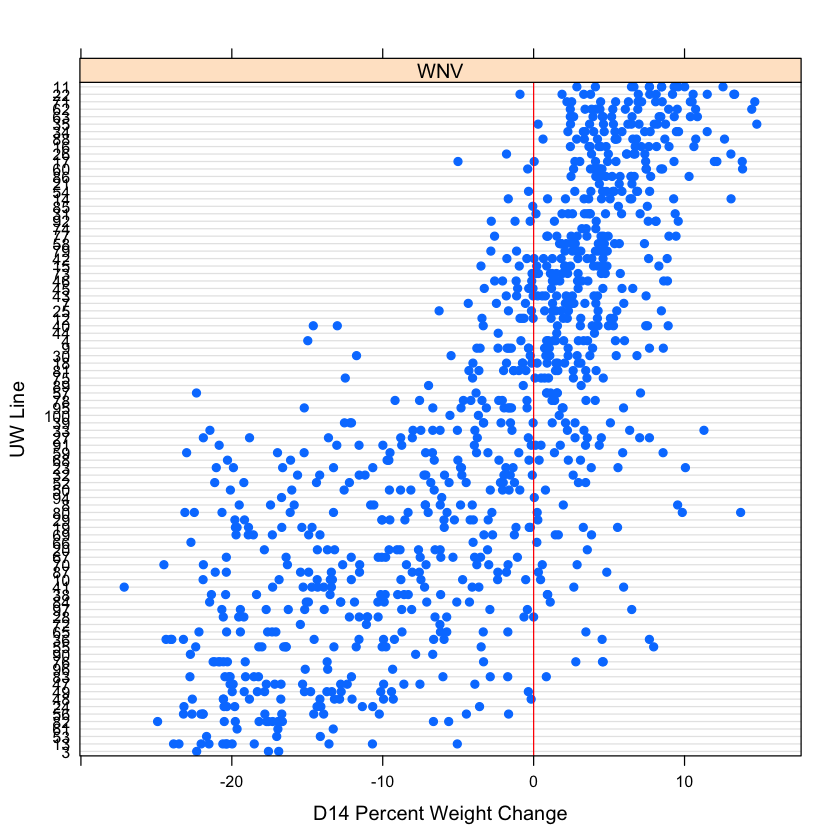

In [6]:
library(lattice)
dotplot(reorder(pheno[,'UW_Line'], pheno[,'d14_percent_wl'], mean, na.rm=T) ~ 
        pheno[,'d14_percent_wl'] | pheno[,'Virus'], 
        panel = function(x,y,...) {panel.dotplot(x,y,...); panel.abline(v=0, col.line="red")}, 
        pch=19, ylab='UW Line', xlab="D14 Percent Weight Change")

In [7]:
## Summarize weight loss per line
pheno_per_line = aggregate(pheno[, 'd14_percent_wl'], list(pheno$UW_Line), median, na.rm=T)
colnames(pheno_per_line) = c('UW_Line', 'median_d14_percent_wl')

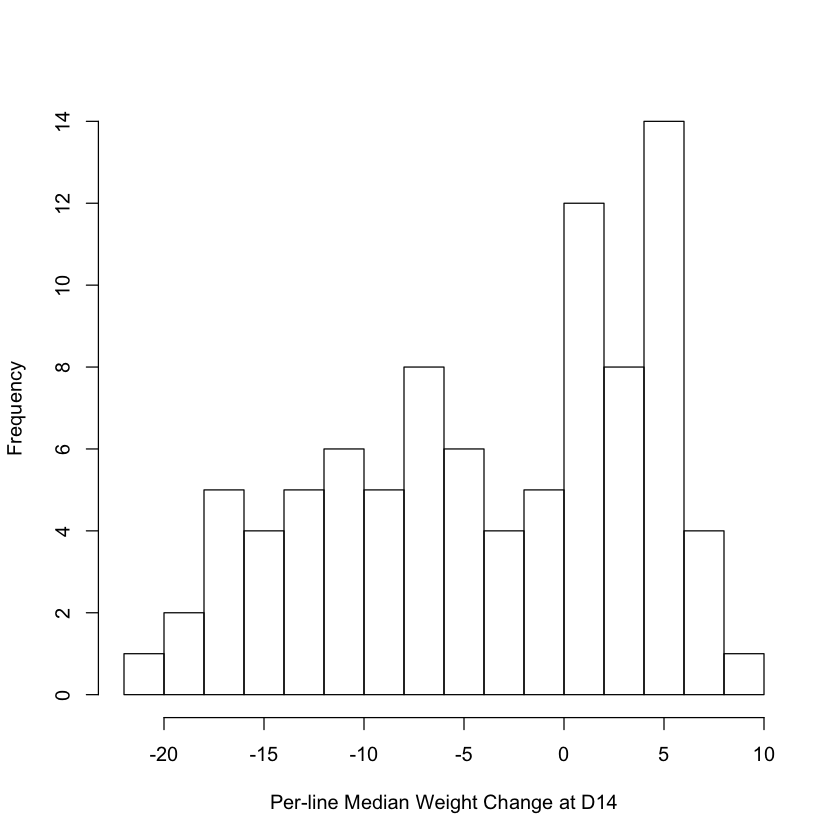

In [8]:
hist(pheno_per_line$median_d14_percent_wl, breaks=20, main="", xlab="Per-line Median Weight Change at D14")

In [9]:
## View extreme lines
pheno_per_line[with(pheno_per_line, median_d14_percent_wl <= -10 | median_d14_percent_wl >= 5), ]

,UW_Line,median_d14_percent_wl
1,3,-17.57426
6,10,-10.43912
7,11,8.075248
9,13,-20.35662
12,16,5.765863
13,17,5.178047
15,19,-10.30418
17,21,5.670611
18,22,7.907562
20,24,-14.35442


In [10]:
## Get extreme lines
extreme_lines = pheno_per_line[with(pheno_per_line, median_d14_percent_wl <= -10 | median_d14_percent_wl >= 5), 1]
## Remove lines that recover by D14
extreme_lines = setdiff(extreme_lines, c(19, 55, 76))
## Subset pheno dataframe
pheno = pheno[pheno$UW_Line %in% extreme_lines,]

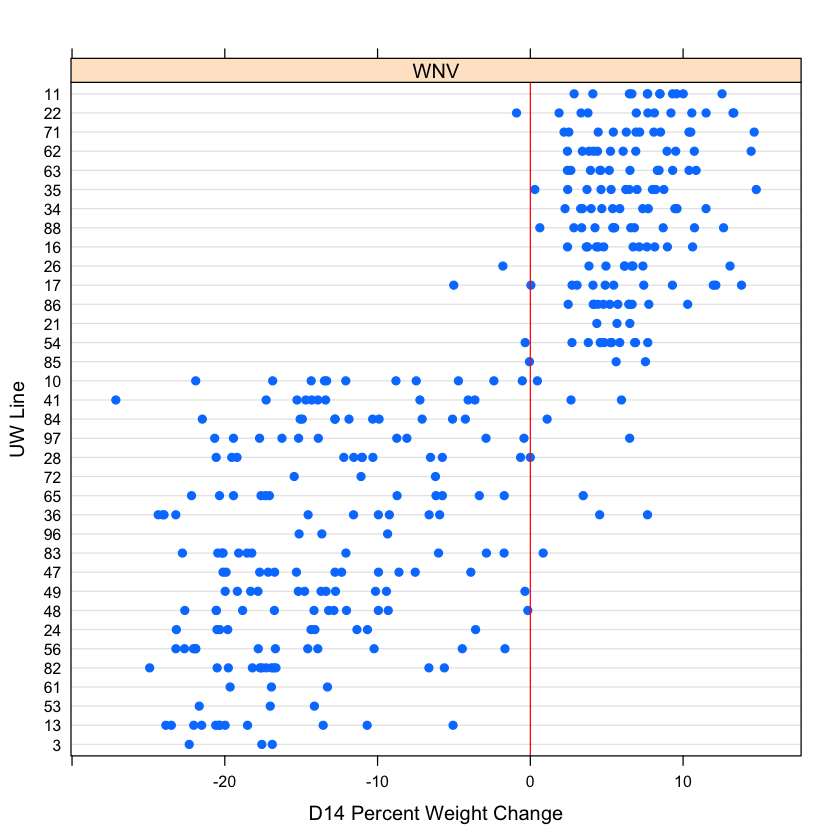

In [11]:
dotplot(reorder(pheno[,'UW_Line'], pheno[,'d14_percent_wl'], mean, na.rm=T) ~ 
        pheno[,'d14_percent_wl'] | pheno[,'Virus'], 
        panel = function(x,y,...) {panel.dotplot(x,y,...); panel.abline(v=0, col.line="red")}, 
        pch=19, ylab='UW Line', xlab="D14 Percent Weight Change")

![Extreme Lines](./images/extreme_lines.png)

[http://church.ohsu.edu:3838/mooneymi/wnv_pheno_time_series/](http://church.ohsu.edu:3838/mooneymi/wnv_pheno_time_series/)

In [ ]:
## Sort pheno dataframe and set rownames
pheno = pheno[with(pheno, order(Mating, RIX_ID)),]
rownames(pheno) = pheno$ID

## Fix sex column name
colnames(pheno)[which(colnames(pheno) == 'Sex')] = 'sex'
dim(pheno)

In [ ]:
## Create covariate dataframe (must include sex)
covar = data.frame(sex = as.numeric(pheno$sex == 'M'))
rownames(covar) = pheno$ID

In [ ]:
## Get IDs and Matings for each sample
samples = pheno$ID
matings = unlist(lapply(strsplit(samples, '_'), function(x) {x[1]}))
matings = unique(matings)

## Step 4. Get Marker Probabilities for Each Sample

In [ ]:
## Read strain ID mapping file
mapping_dir = '/Users/mooneymi/Documents/MyDocuments/SystemsImmunogenetics/Mapping'
strain_map = read.xls(file.path(mapping_dir, 'RIXTrueIDs.xlsx'), header=T, as.is=T)
colnames(strain_map) = c('Mating', 'CC_Mating', 'Notes')

head(strain_map)

In [ ]:
## Check that matings match the strain mapping file
setdiff(matings, strain_map$Mating)

In [ ]:
## Correct the mismatched matings
pheno$Mating[pheno$Mating == '3609x5119'] = '3609x15119'
pheno$Mating[pheno$Mating == '8018x3154'] = '18018x3154'

pheno$ID = paste0(pheno$Mating, '_', pheno$RIX_ID)
rownames(pheno) = pheno$ID
rownames(covar) = pheno$ID

samples = pheno$ID
matings = unlist(lapply(strsplit(samples, '_'), function(x) {x[1]}))
matings = unique(matings)

In [ ]:
## Get all file names for CC probability files
cc_prob_files = list.files(mapping_dir, pattern="CC...-.*b38.*\\.csv")

In [ ]:
## Map RIX matings to CC matings
cc_matings = sapply(matings, function(x) {strain_map$CC_Mating[strain_map$Mating == x]}, USE.NAMES=F)

## Get unique vector of parental strains
rix_strains = unlist(strsplit(matings, 'x'))
cc_strains = unlist(strsplit(cc_matings, 'x'))

## Check strains
dup_idx = duplicated(cc_strains)
cc_strains = cc_strains[!dup_idx]
names(cc_strains) = rix_strains[!dup_idx]
cc_strains[1:5]

In [ ]:
## Iterate through matings and save the 8-state probability file
## for each parental line as a .csv file (RIX IDs will be used for the file names)
rix_dir = '/Users/mooneymi/Documents/MyDocuments/SystemsImmunogenetics/Mapping/RIX'
for (i in 1:length(cc_strains)) {
    ## Get RIX ID
    rix = names(cc_strains[i])
    
    ## Create and save the 8-state probabilities for each parental strain
    cc_file = file.path(mapping_dir, cc_prob_files[grep(paste0(cc_strains[i], '-.*\\.csv'), cc_prob_files)])
    cc_8state = collapse_probs(cc_file)
    
    ## Save Y and M chromosomes separately
    autosome_x_markers = cc_8state$marker[!cc_8state$chromosome %in% c('Y', 'M')]
    y_m_markers = cc_8state$marker[cc_8state$chromosome %in% c('Y', 'M')]
    file_name = file.path(rix_dir, paste0(rix, '.csv'))
    write.table(cc_8state[autosome_x_markers, ], file=file_name, row.names=F, col.names=T, sep=',', quote=F)
    file_name = file.path(rix_dir, paste0(rix, '_Y_M.csv'))
    write.table(cc_8state[y_m_markers, ], file=file_name, row.names=F, col.names=T, sep=',', quote=F)
}

## Step 5. Construct 3D Array of Probabilities

In [ ]:
## Create model.probs object needed for DOQTL (an N x 8 x M array; N=samples, M=markers)
## This function will run fastest when samples are ordered by mating
model.probs = make_rix_model_probs(samples, rix_dir)

In [ ]:
## Might help free memory
gc()

In [ ]:
## Check dimensions and shape of model.probs object
dim(model.probs)
names(dimnames(model.probs))

In [ ]:
## Check model.probs object
model.probs[1,,1:5]

In [ ]:
## Get vector of all markers
all_markers = dimnames(model.probs)[[3]]

## Check if any markers sum to 0
markers_zero_idx = which(apply(model.probs, 1, colSums) == 0)
markers_zero = rep(all_markers, length(samples))[markers_zero_idx]
markers_zero = markers_zero[!is.na(markers_zero)]
markers_zero = unique(markers_zero)
length(markers_zero)

In [ ]:
## Check if any markers don't sum to 1 (Optional)
## WARNING: This can take quite a while
prob_sums = apply(model.probs, 1, colSums)
prob_sums_not_one = sapply(prob_sums, function(x) {!isTRUE(all.equal(x, 1))})
markers_not_one_idx = which(prob_sums_not_one)
markers_not_one = rep(all_markers, length(samples))[markers_not_one_idx]
markers_not_one = markers_not_one[!is.na(markers_not_one)]
markers_not_one = unique(markers_not_one)
length(markers_not_one)

In [ ]:
## Save markers with all zeros to file
write.table(data.frame(marker=markers_zero), file='markers_all_zeros.txt', sep='\t', col.names=T, row.names=F, quote=F)

In [ ]:
## Remove markers with all zeros
model.probs = model.probs[, , setdiff(all_markers, markers_zero)]
dim(model.probs)

In [ ]:
## Make all probabilities non-zero
model.probs[model.probs == 0] = 1e-20

In [ ]:
## Check model.probs object
model.probs[1,,1:5]

In [ ]:
## Save model.probs object to file (optional)
save(model.probs, file="rix_model_prob_test.rda")

## Step 6. Calculate Kinship Matrix

In [ ]:
## Create kinship probability matrix
K = kinship.probs(model.probs)

In [ ]:
## Might help free memory
gc()

In [ ]:
## Check kinship matrix
K[1:5, 1:5]

## Step 7. Perform QTL Scan

In [ ]:
## First get marker positions
marker_pos = read.csv(file.path(mapping_dir, 'CC001-Uncb38V01.csv'), as.is=T)
marker_pos = marker_pos[,1:3]
marker_pos$position_cM = NA
head(marker_pos)

In [ ]:
## Run QTL scan
qtl = scanone(pheno=pheno, pheno.col='d14_percent_wl', probs=model.probs, K=K, addcovar=covar, snps=marker_pos)

In [ ]:
perms = scanone.perm(pheno = pheno, pheno.col = 'd14_percent_wl', probs = model.probs, 
                     addcovar = covar, snps = marker_pos, nperm = 1000)

In [ ]:
thr = quantile(perms, probs = 0.95)

## Step 8. Identify QTL Intervals

In [ ]:
plot(qtl, sig.thr = thr, main = 'd14_percent_wl')

In [ ]:
coefplot(qtl, chr = 7)

In [ ]:
interval = bayesint(qtl, chr = 7)

## Step 9. Perform Association Mapping within QTL Intervals

In [ ]:
ma = assoc.map(pheno = pheno, pheno.col = 'd14_percent_wl', probs = model.probs, K = K, 
               addcovar = covar, snps = marker_pos, chr = interval[1,2], 
               start = interval[1,3], end = interval[3,3])